In [ ]:
import os
import json
import requests
from dotenv import load_dotenv

load_dotenv()

In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

In [ ]:
api_key = os.getenv("API-KEY")
headers = {"Authorization":
           f"Bearer {api_key}"}

In [ ]:
def get_quizzes(course_id, headers):
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes", headers=headers)
    raw = r.json()
    for i in raw:
        i["course_id"] = course_id
    return raw

In [ ]:
def get_submissions(course_id, quiz_id):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    Example ids used, not real
    jsons = get_submissions(400, 1000)
    with open("some_json_title.json", "w") as outfile:
        json.dump(data_set, outfile)
    """
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions", headers=headers)
    data_set = []
    raw = r.json()

    for submission in raw["quiz_submissions"]:
        submission["course_id"] = course_id
        submission["quiz_id"] = quiz_id
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw["quiz_submissions"]:
                submission["course_id"] = course_id
                submission["quiz_id"] = quiz_id
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/accounts/1/courses?search_by=course&search_term=LLP&per_page=100", headers=headers)
r

In [ ]:
raw = r.json()

with open("LLP-Courses.json", "w") as outfile:
    json.dump(raw, outfile)

In [ ]:
llp_courses_df = pd.read_json("LLP-Courses.json")
llp_courses_df.head()

In [ ]:
llp_no_temp = llp_courses_df[llp_courses_df["course_code"].str.contains("Template")==False]
llp_no_temp.head()

In [ ]:
llp_2011_2010 = llp_no_temp[(llp_no_temp["course_code"].str.contains(pat = "201\d", regex = True))]
llp_2011_2010.head()

In [ ]:
quizzes_data = []
for i in llp_2011_2010["id"]:
    for t in get_quizzes(i, headers):
        quizzes_data.append(t)

In [ ]:
with open("quizzes_llp_201X.json", "w") as outfile:
    json.dump(quizzes_data, outfile)

In [ ]:
quizzes_df = pd.read_json("quizzes_llp_201X.json")
quizzes_df[["id","title", "course_id"]].head()

In [ ]:
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6780/submissions", headers=headers)
data_set = []
raw = r.json()

In [ ]:
for i in raw["quiz_submissions"]:
    i["course_id"] = 495 

In [ ]:
for i in quizzes_df[["id", "course_id"]].itertuples():
    submissions = get_submissions(i.course_id, i.id)
    with open(f"submissions_{i.id}.json", "w") as outfile:
        json.dump(submissions, outfile)

In [ ]:
subs_6585_df = pd.read_json("submissions_6585.json")
subs_6585_df.head()

In [ ]:
course_id = subs_6585_df["course_id"][1]
quiz_id = subs_6585_df["quiz_id"][1]
started_at = subs_6585_df["started_at"][0]
sub_id = subs_6585_df["id"][1]
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers) 

In [ ]:
raw2 = r.json()

for i in raw2["quiz_submission_events"]:
    if "event_data" in i.keys():
        if i["event_type"] == "question_answered":
            for t in i["event_data"]:
                if t["answer"] != None and 0 < t["answer"] < 4:
                    print(t["answer"]) 

In [ ]:
import glob
subs_df = pd.DataFrame()
path_to_json = ""
json_pattern = os.path.join(path_to_json, "submissions_*.json")
files_list = glob.glob(json_pattern)

for f in files_list:
    data = pd.read_json(f)
    subs_df = subs_df.append(data)

In [ ]:
subs_df

In [ ]:
course_495 = subs_df[subs_df["course_id"]==495]
course_495

In [ ]:

result_data = []
for row in course_495[["id","user_id","quiz_id","started_at","course_id"]].iterrows():
    sub_id = row[1][0]
    user_id = row[1][1]
    quiz_id = row[1][2]
    started_at = row[1][3]
    course_id = row[1][4]
    r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{sub_id}/events", headers=headers)
    raw = r.json()
    for i in raw["quiz_submission_events"]:
        if "event_data" in i.keys():
            if i["event_type"] == "question_answered":
                for t in i["event_data"]:
                    if t["answer"] != None and isinstance(t["answer"], float):
                        if t["answer"] != None and 0 < t["answer"] < 4:
                            result_data.append([user_id, t["answer"], started_at]) 

In [ ]:
result_data[0]

In [38]:
result_df = pd.DataFrame(result_data, columns=["user_id", "score", "started_at"])
result_df.head()

,user_id,score,started_at
0,633,3.0,2020-10-26 22:47:46+00:00
1,544,2.0,2020-10-26 23:08:10+00:00
2,1011,2.0,2020-10-26 23:11:21+00:00
3,631,2.0,2020-10-26 23:31:11+00:00
4,2797,3.0,2020-10-26 23:34:29+00:00


In [ ]:
result_table = result_df.pivot_table(index="started_at")
result_table

In [ ]:
result_df["user_id"].unique()

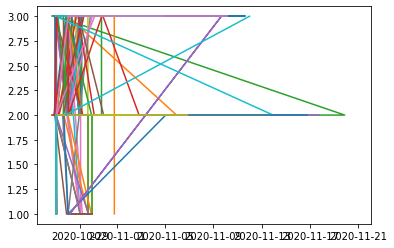

In [41]:
import matplotlib.pyplot as plt
for i in result_df["user_id"].unique():
    df = result_df[result_df["user_id"]==i]
    plt.plot(df["started_at"], df["score"])
plt.show()

In [ ]:
result_pivot = result_df.pivot(index="started_at", columns="user_id", values="score")
result_pivot.plot()

In [ ]:
st_544 = []
for i in result_data:
    if i[0] == 544:
        st_544.append(i)

In [ ]:
st_633 = []
for i in result_data:
    if i[0] == 633:
        st_633.append(i)

In [ ]:
st_544_633 = st_544+st_633
st_544_633

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i[2] for i in st_633], [i[1] for i in st_633])

In [ ]:
counts = {3:0,2:0,1:0}
for i in result_data:
    if i[1] == 1:
        counts[1]+=1
    if i[1] == 2:
        counts[2]+=1
    if i[1] == 3:
        counts[3]+=1
counts

In [ ]:
import matplotlib.pyplot as plt

plt.bar(counts.keys(),counts.values(), color=["green", "grey", "red"])

In [ ]:
result_data
[i for i in result_data if i[0]==633]

In [ ]:
user_633 = course_495[course_495["user_id"]==633]
user_633

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions", headers=headers)
r

In [ ]:
raw = r.json()

with open("submissions-6617.json","w") as outfile:
    json.dump(raw["quiz_submissions"], outfile)

In [ ]:
sub_df_6617 = pd.read_json("submissions-6617.json")
sub_df_6617.head()

In [ ]:
r = requests.get("https://lambdaschool.instructure.com/api/v1/courses/495/quizzes/6617/submissions/57046/events", headers=headers)
r

In [ ]:
raw = r.json()["quiz_submission_events"]
for i in raw:
    i["user_id"] = 530

In [ ]:
with open("events-57046.json", "w") as outfile:
    json.dump(raw, outfile)

In [ ]:
events_df_57046 = pd.read_json("events-57046.json")
events_df_57046

In [ ]:
def get_submissions(r):
    """Creates a small list of jsons
    that can be made into a file very easily
    then converted to a dataframe for exploration
    This particular design is just for grabbing pagniated
    information from the api and returning it in a useful
    way.
    Usage:
    jsons = get_submissions(valid_api_request)"""
    data_set = []
    raw = r.json()

    for submission in raw:
        data_set.append(submission)

    if "next" in r.links.keys():
        while "next" in r.links.keys():
            r = requests.get(r.links["next"]["url"], headers=headers)
            raw = r.json()
            for submission in raw:
                data_set.append(submission)
        if "last" in r.links.keys() and r.links['current']['url'] == r.links['last']['url']:
            print('Done!')
    else:
        print("Just one page!")
    return data_set

In [ ]:

def get_answer(df):
    for i in df["event_data"]:
        if isinstance(i, list) and isinstance(i[0], str)==False:
            if "22635" in i[0].values():
                print(i[0]["answer"])
get_answer(events_df_56623)

In [ ]:
course_id = 495
quiz_id = 6780
submission_id = 56623
r = requests.get(f"https://lambdaschool.instructure.com/api/v1/courses/{course_id}/quizzes/{quiz_id}/submissions/{submission_id}/events", headers=headers)
r